In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants, index_tools, data_tools, medical_code_tools

from utilities import *

if is_jupyter_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

# Data Index

In [2]:
biobank_index_full = index_tools.load_index()

In [3]:
biobank_index_full = index_tools.add_udi_names_to_index(biobank_index_full)
biobank_index_full["primary_udi"] = biobank_index_full["udi"].apply(lambda s: s.split("-")[0])

In [4]:
missing_name_index = index_tools.get_indices_missing_names(biobank_index_full)
print("Still missing", len(biobank_index_full.loc[biobank_index_full["name"].isna()]), "names")

for i in range(4):
    biobank_index_full.loc[biobank_index_full["udi"] == f"20199-2.{i}", "name"] = f"antibiotic_codes_past_3_months_2.{i}"

biobank_index_full.loc[biobank_index_full["udi"] == "6671-2.0", "name"] = f"n_antibiotics_past_3_months"

Still missing 5 names


In [5]:
biobank_index_full.loc[biobank_index_full["udi"] == f"20199-2.3"]

,column,udi,count,type,description,data_code,name,primary_udi
1762,1762,20199-2.3,2,Categorical (multiple),Antibiotic codes for last 3 months,744,antibiotic_codes_past_3_months_2.3,20199


In [6]:
udi_map = index_tools.UDIMap(biobank_index_full)

# Load BioBank Data

In [7]:
correct_feature_typing = False
biobank_data_full = data_tools.load_biobank_data(constants.UK_BIOBANK_DATA_CSV_PATH, udi_map)
biobank_index_full = index_tools.add_biobank_info_to_index(biobank_index_full, biobank_data_full)

features = biobank_index_full.query("type == 'Continuous' or type == 'Integer'")["name"]
biobank_data_full = biobank_data_full.astype({feature: 'float' for feature in features})

display(biobank_data_full.head())

UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns


,eid,verbal_interview_duration,verbal_interview_duration_1.0,verbal_interview_duration_2.0,sex,birth_year,bp_device,bp_device_1.0,bp_device_2.0,bp_manual_device_ID,...,operative_procedures_OPCS4_secondary_0.82,operative_procedures_OPCS4_secondary_0.83,operative_procedures_OPCS4_secondary_0.84,operative_procedures_OPCS4_secondary_0.85,important_unlabeled_34,inpatient_record_format,inpatient_record_format_0.1,inpatient_record_format_0.2,inpatient_record_format_0.3,inpatient_record_format_0.4
0,1000013,485.0,NaN,NaN,1,1962.0,002817,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18,NaN,NaN,NaN,NaN
1,1000024,328.0,NaN,NaN,0,1941.0,001054,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6,NaN,NaN,NaN,NaN
2,1000036,364.0,NaN,NaN,0,1955.0,003159,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6,NaN,NaN,NaN,NaN
3,1000048,322.0,NaN,NaN,1,1941.0,003780,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18,NaN,NaN,NaN,NaN
4,1000055,477.0,NaN,NaN,0,1947.0,003156,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,6,18,NaN,NaN,NaN


In [8]:
biobank_data_full[["illness_code", "illness_code_0.1", "treatment_code"]]

,illness_code,illness_code_0.1,treatment_code
0,1065,1465,1140884488
1,NaN,NaN,NaN
2,NaN,NaN,1140870164
3,1065,1637,1140860696
4,1075,1074,1140868226
...,...,...,...
9994,NaN,NaN,1140870200
9995,1074,1065,1140861138
9996,NaN,NaN,NaN
9997,1142,1505,1140871050


In [9]:
biobank_index_full.type.unique()

array(['Sequence', 'Integer', 'Categorical (single)', 'Text', 'Date',
       'Continuous', 'Categorical (multiple)', 'Time', 'Curve'],
      dtype=object)

# Clean + Reduce feature set

In [10]:
biobank_data = data_tools.clean_biobank_data(biobank_data_full)

biobank_data = biobank_data
biobank_index = biobank_index_full

# BioBank Code Download

In [11]:
medical_code_tools.download_all_biobank_codes(biobank_index, overwrite=False, suppress=True);

# BioBank Code Intersections

In [12]:
med_code_mapping = medical_code_tools.MedicalCodeMapping(biobank_index) 

In [13]:
med_code_mapping.build_tree(code_format="1001");

ethnic_background_2.0
├── Asian or Asian British (3)
│   ├── Any other Asian background (3004)
│   ├── Bangladeshi (3003)
│   ├── Indian (3001)
│   └── Pakistani (3002)
├── Black or Black British (4)
│   ├── African (4002)
│   ├── Any other Black background (4003)
│   └── Caribbean (4001)
├── Chinese (5)
├── Do not know (-1)
├── Mixed (2)
│   ├── Any other mixed background (2004)
│   ├── White and Asian (2003)
│   ├── White and Black African (2002)
│   └── White and Black Caribbean (2001)
├── Other ethnic group (6)
└── White (1)
    ├── Any other white background (1003)
    ├── British (1001)
    └── Irish (1002)



In [14]:
with Timer() as t:
    values = {}
    for feature in tqdm(biobank_data.columns, desc="Mapping ICD10 Codes", unit=" feature"):
        values[feature] = med_code_mapping.decode(biobank_data[feature], name=feature)
    biobank_data = pd.DataFrame(values)
t.print_time()

Mapping ICD10 Codes:   0%|          | 0/2018 [00:00<?, ? feature/s]

Elapsed time: 9.5264 seconds


In [15]:
med_code_mapping.search_codes("mononucleosis").head()

,coding,meaning,code_format,feature
361,1567,infectious mononucleosis / glandular fever / e...,6,illness_code
1,9,No,100258,birth_weigh_known
1,0,No,100564,None
0,0,No,503,GI_IBS_initial_symptoms_co-occuring_infection
1,0,No,100349,birth_maternal_smoking


In [16]:
biobank_data["cancer_code"]

0                               NaN
1                malignant melanoma
2                     breast cancer
3                               NaN
4                               NaN
                   ...             
9994    liver/hepatocellular cancer
9995                  breast cancer
9996                            NaN
9997                            NaN
9998                            NaN
Name: cancer_code, Length: 9999, dtype: object

In [18]:
index_tools.term_search(biobank_index, "cancer")

['cancer_first_year_age',
 'cancer_first_year_age_0.1',
 'cancer_first_year_age_0.2',
 'cancer_first_year_age_0.3',
 'cancer_first_year_age_0.4',
 'cancer_first_year_age_0.5',
 'cancer_first_year_age_1.0',
 'cancer_first_year_age_1.1',
 'cancer_first_year_age_1.2',
 'cancer_first_year_age_1.3',
 'cancer_first_year_age_1.4',
 'cancer_first_year_age_1.5',
 'cancer_first_year_age_2.0',
 'cancer_first_year_age_2.1',
 'cancer_first_year_age_2.2',
 'cancer_first_year_age_2.3',
 'cancer_first_year_age_2.4',
 'cancer_first_year_age_2.5',
 'illness_first_year_age',
 'illness_first_year_age_0.1',
 'illness_first_year_age_0.2',
 'illness_first_year_age_0.3',
 'illness_first_year_age_0.4',
 'illness_first_year_age_0.5',
 'illness_first_year_age_0.6',
 'illness_first_year_age_0.7',
 'illness_first_year_age_0.8',
 'illness_first_year_age_0.9',
 'illness_first_year_age_0.10',
 'illness_first_year_age_0.11',
 'illness_first_year_age_0.12',
 'illness_first_year_age_0.13',
 'illness_first_year_age_0.14'

In [126]:
biobank_data[["illness_dx_age_interpolated_0.1","illness_dx_recording_time_method_0.1",
              "illness_first_year_age_0.1"]].dropna()

,illness_dx_age_interpolated_0.1,illness_dx_recording_time_method_0.1,illness_first_year_age_0.1
0,41.2219,-5,2003.0
3,48.2035,-5,1989.0
4,53.5000,Age at event,53.0
5,28.6795,-5,1975.0
9,48.2719,-5,2003.0
...,...,...,...
9988,16.5000,Age at event,16.0
9989,19.5000,Age at event,19.0
9990,56.0476,-5,2004.0
9995,28.5000,Age at event,28.0


In [160]:
biobank_data["sex"]

0       Male
1          0
2          0
3       Male
4          0
        ... 
9994    Male
9995       0
9996       0
9997    Male
9998       0
Name: sex, Length: 9999, dtype: object

# Feature Exploration

In [127]:
feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
    unique_features = biobank_data[column].unique()
    feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
    feature_data["feature"].append(column)
    feature_data["n_unique"].append(len(unique_features))
    
feature_data = pd.DataFrame(feature_data)

Analyzing features:   0%|          | 0/2018 [00:00<?, ? feature/s]

# Feature Index EDA

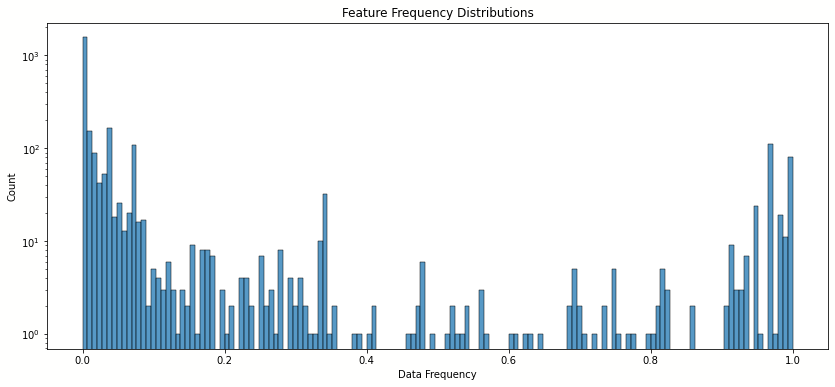

In [128]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.histplot(biobank_index_full["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fffffe")

# actual EDA

In [129]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

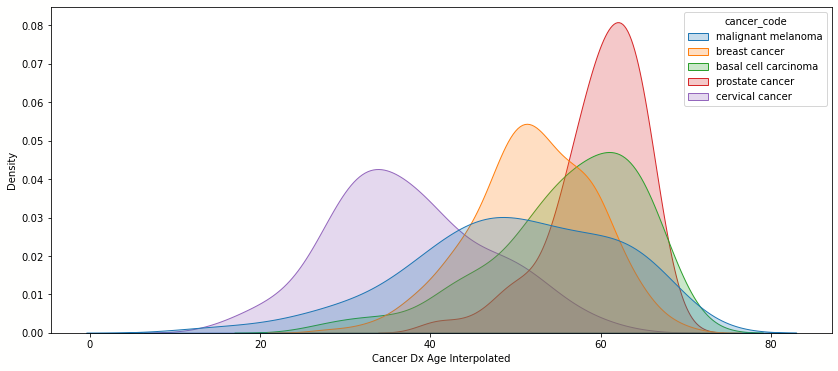

In [158]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False,)

add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_onset_age.png"), facecolor="#fffffe")

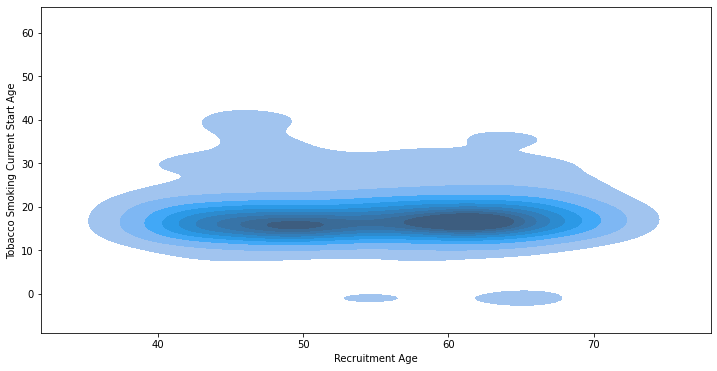

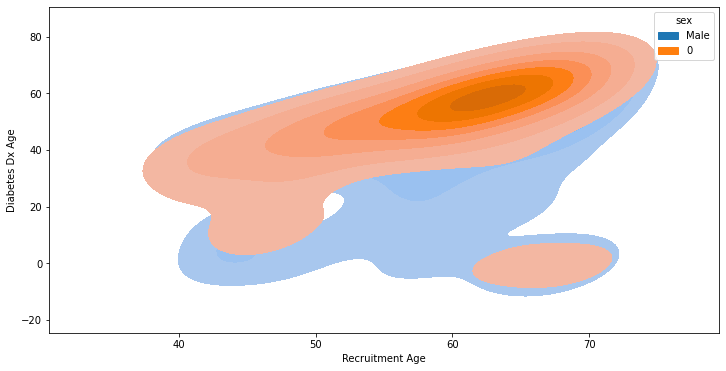

In [159]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"

sns.kdeplot(data=biobank_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

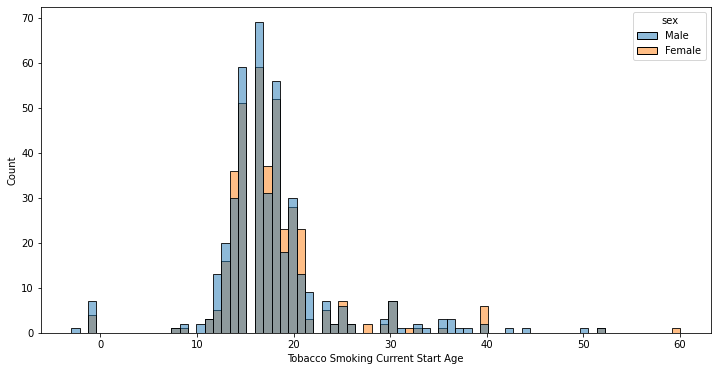

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
x="tobacco_smoking_current_start_age"
sns.histplot(data=biobank_data, x=x, hue="sex",  ax=ax)
add_plt_labels(ax, x, y="Count")

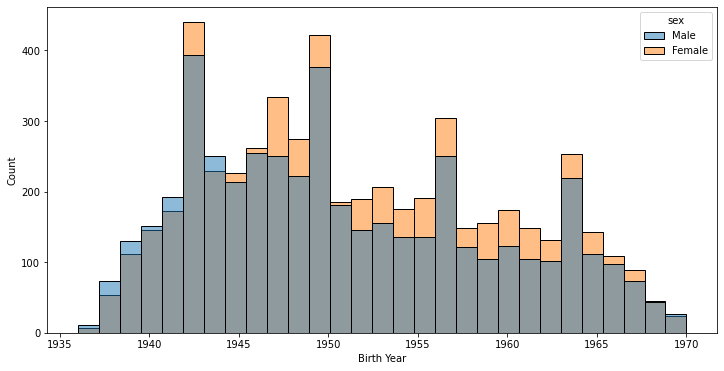

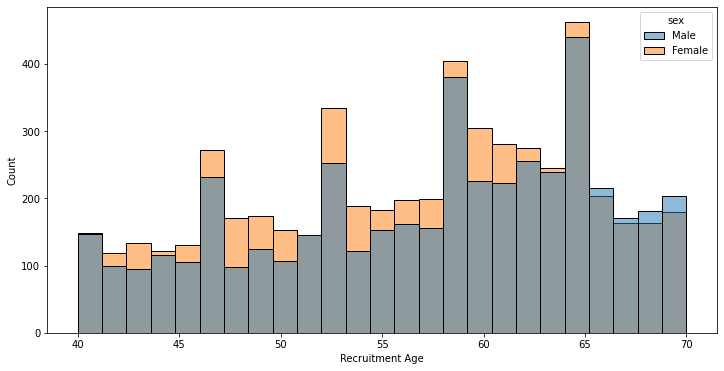

In [90]:
x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")